## 1. 3 areas in industry where computer vision currently used:
* EV
* Photograph
* Calorie app

# 2. What is overfitting in machine learning:
* Undesirable machine learning behaviour that occurs when the machine learning model gives accurate predictions for training data but not for new data

## 3. Ways to prevent overfitting in machine learning:
* Increase model complexity or data amount
* Reduce model complexity
* Regularization
 - L1 and L2 penalty for model
* Cross validation

## Start making a model here

### 1. Import all of the library

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import requests
from pathlib import Path
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
from timeit import default_timer as timer

### 1.a. Helper functions

In [2]:

# Download helper function from pytorch repo
if Path("helper_function.py").is_file():
  print("Downloaded")
else:
  print("Downloading the file")
  requests = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(requests.content)

from helper_functions import accuracy_fn


### 2. Get the dataset

In [3]:
# Training data
train_data = datasets.FashionMNIST(
    root = "Data",
    train=True,
    download = True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

# Test data
test_data = datasets.FashionMNIST(
    root = "Data",
    train = False,
    download = True,
    transform= ToTensor(),
    target_transform = None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.9MB/s]


### 3. Visualize at least 5 different sample

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


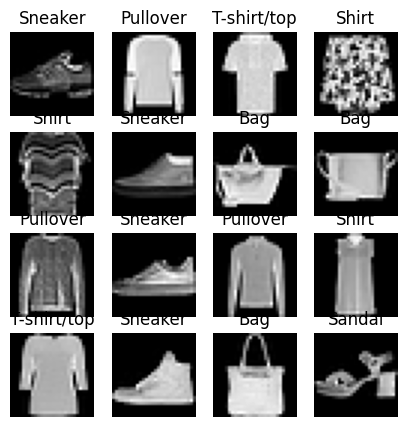

In [4]:
class_names = train_data.classes
print(class_names)
class_to_idx = train_data.class_to_idx
print(class_to_idx)


fig = plt.figure(figsize=(5,5))
rows, cols = 4,4
for i in range( 1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

### 4. Turn MNIST train and test datasets into data loader

In [5]:
batch_size = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = batch_size,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = batch_size,
                             shuffle=False)

print(f"Length of train_dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {batch_size}")

Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


### 5. Create model

In [6]:
# FashionMNIST
class FashionMNIST(nn.Module):
  def __init__(self,
               input_shape : int,
               hidden_units : int,
               output_shape : int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7,
                  out_features = output_shape)
    )

  def forward (self, x):
     x = self.conv_block_1(x)
     x = self.conv_block_2(x)
     x = self.classifier(x)

     return x



In [7]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [20]:
model = FashionMNIST(input_shape = 1,
                     hidden_units = 10,
                     output_shape = len(class_names)).to(device)

In [21]:
# Make the optimizer and loss function
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
optimizer = torch.optim.SGD(params=model.parameters(), # tries to update our model parameters to reduce the loss
                            lr=0.1)


In [22]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Perform a training with model trying to learn on data_loader"""
  train_loss, train_acc = 0,0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X,y) in enumerate(data_loader):
    # Make our data device agnostic
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (output the raw logits from the model)
    y_pred = model(X)

    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true = y,
                             y_pred=y_pred.argmax(dim=1))
    # 3. Optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer.step
    optimizer.step()

  # Divice total train loss and accuracy by length of train dataloader
  train_loss /= len(train_dataloader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

In [23]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  """Performs a testing loop step on model going over data_loader"""
  test_loss, test_acc = 0, 0
  # Put model in eval mode
  model.eval()

  # Use inference mode
  with torch.inference_mode():
    for X, y, in data_loader:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (output raw logits)
      test_pred = model(X)

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true= y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels

    # Calculate the test loss average per batch
    test_loss /= len(data_loader)

    # Calculate the test loss average per batch
    test_acc /= len(data_loader)

    # Print out
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [34]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 5

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model=model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model,
            data_loader = test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  train_time_end_on_gpu = timer()

  total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu,
                                              end=train_time_end_on_gpu,
                                              device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.59388 | Train Acc: 78.45%
Test loss: 0.40053 | Test acc: 85.44%
Train time on cuda: 11.433 seconds
Epoch: 1
Train loss: 0.36178 | Train Acc: 87.03%
Test loss: 0.35461 | Test acc: 86.62%
Train time on cuda: 22.840 seconds
Epoch: 2
Train loss: 0.32377 | Train Acc: 88.24%
Test loss: 0.32628 | Test acc: 88.08%
Train time on cuda: 34.195 seconds
Epoch: 3
Train loss: 0.30432 | Train Acc: 88.82%
Test loss: 0.33165 | Test acc: 87.78%
Train time on cuda: 45.565 seconds
Epoch: 4
Train loss: 0.29050 | Train Acc: 89.45%
Test loss: 0.29911 | Test acc: 89.39%
Train time on cuda: 56.820 seconds


In [35]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make data device agnostic
      X,y = X.to(device), y.to(device)

      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, #only works when mode was created
          "model_loss": loss.item(),
          "model_acc": acc}

In [36]:
model_results = eval_model(model=model,
                             data_loader = test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.29910874366760254,
 'model_acc': 89.38698083067092}

### 5. Evaluate random prediction

In [37]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model output raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculation
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_prob to turn list into tensor
  return torch.stack(pred_probs)

In [38]:
import random

test_samples = []
test_labels = []
for sample, label in random.sample (list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample sha
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Trouser')

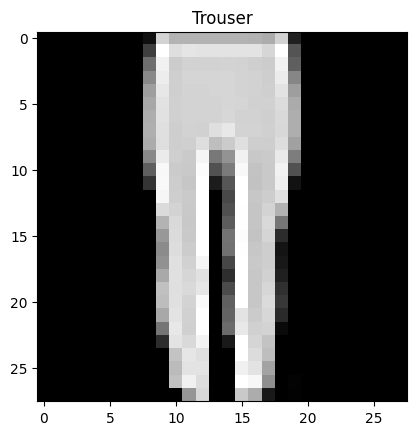

In [39]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])


In [40]:
# Make predictions
pred_probs = make_predictions(model= model,
                              data=test_samples)

# Ve=iew first two prediction probabilities
pred_probs[:2]

tensor([[2.4830e-05, 9.9997e-01, 5.3724e-09, 1.9404e-06, 1.3507e-06, 1.6510e-07,
         2.0914e-06, 2.2538e-09, 3.2681e-08, 7.8452e-09],
        [2.1058e-04, 1.3284e-04, 2.6524e-02, 8.6478e-06, 9.3835e-01, 4.2506e-05,
         3.4644e-02, 2.5343e-07, 3.4234e-05, 5.5508e-05]])

In [41]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes


tensor([1, 4, 9, 4, 8, 6, 9, 5, 9])

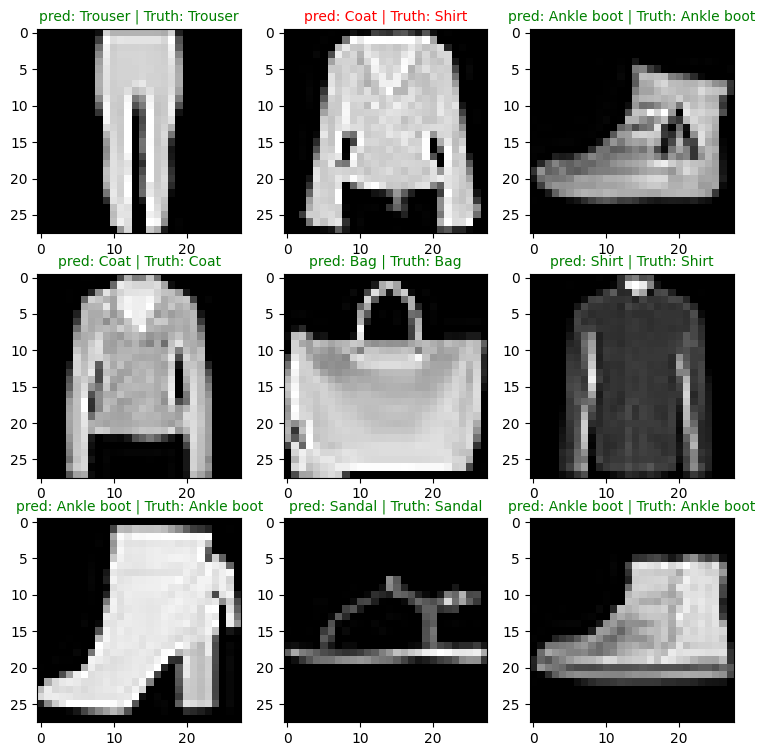

In [43]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # create a title for the plot
  title_text = f"pred: {pred_label} | Truth: {truth_label}"

  # Check for equallity between pred and truth and change color
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c="g") # green text if prediction same as truth

  else:
    plt.title(title_text, fontsize=10, c = "r")